---
title: "fastai snippets"
description: "Useful fastai code snippets"
categories: [code snippets, jupyter, python]
date: "2020-03-18"
toc: true
---

Currently using fastai2.  
Installation via `pip install fastai2`.

## Oversampling

In [3]:
from fastai2.tabular.all import *
titanic = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv')

In [23]:
cat_vars = ['survived', 'pclass', 'sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone']
cont_vars = ['age', 'sibsp', 'parch', 'fare']
dep_var = 'alive'
procs = [Categorify, FillMissing, Normalize]
block_y = CategoryBlock()
splits = RandomSplitter()(range_of(titanic))

In [24]:
to = TabularPandas(titanic, procs=procs, cat_names=cat_vars, cont_names=cont_vars,
                   y_names=dep_var, block_y=block_y, splits=splits)

In [27]:
to.items

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_na,sibsp_na,parch_na,fare_na
143,1,3,2,-0.799442,-0.464437,-0.467832,-0.509204,2,3,2,2,0,2,0,2,1,1,1,1
376,2,3,1,-0.568123,-0.464437,-0.467832,-0.498856,3,3,3,1,0,3,1,2,1,1,1,1
853,2,1,1,-1.030761,-0.464437,0.815107,0.166542,3,1,3,1,4,3,1,1,1,1,1,1
333,1,3,2,-1.030761,1.242489,-0.467832,-0.276367,3,3,2,2,0,3,0,1,1,1,1,1
791,1,2,2,-1.030761,-0.464437,-0.467832,-0.110793,3,2,2,2,0,3,0,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,1,3,2,0.202940,0.389026,-0.467832,-0.320865,3,3,2,2,0,3,0,1,1,1,1,1
654,1,3,1,-0.876548,-0.464437,-0.467832,-0.509204,2,3,3,1,0,2,0,2,1,1,1,1
802,2,1,2,-1.416293,0.389026,2.098045,1.834694,3,1,1,1,2,3,1,1,1,1,1,1
257,2,1,1,0.048727,-0.464437,-0.467832,1.141355,3,1,3,1,2,3,1,2,1,1,1,1


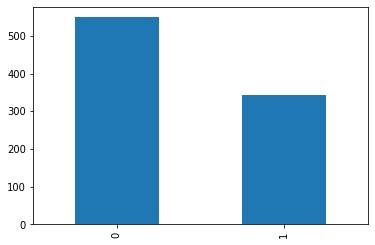

In [29]:
to.items.alive.value_counts().plot.bar();

In [30]:
dls = to.dataloaders()

In [62]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

The `get_idxs` method of DataLoaders samples the `idxs` to be used in an epoch of training:

In [63]:
learn.dls.get_idxs()[:10]

[412, 122, 391, 38, 310, 400, 316, 320, 57, 500]

In [64]:
len(learn.dls.get_idxs())

700

In [65]:
df = pd.DataFrame(1 / learn.dls.items.alive.value_counts())

In [66]:
weights = learn.dls.items.alive.apply(lambda x: df.to_dict()['alive'][x])

In [67]:
learn.dls.train.items.sample(n=700, weights=weights, replace=True).alive.value_counts()

0    352
1    348
Name: alive, dtype: int64

In [68]:
def sample_epoch(self):
    df = pd.DataFrame(1 / self.items.alive.value_counts())
    weights = self.items.alive.apply(lambda x: df.to_dict()['alive'][x])
    self.n = 700 # going for bigger epochs as this will require quite a bit of training
    oversampled_idxs = self.items.sample(n=self.n, weights=weights, replace=True).index
    return [np.where(self.items.index == i)[0][0] for i in oversampled_idxs]

In [69]:
learn.dls.train.get_idxs = types.MethodType(sample_epoch, learn.dls.train)

In [70]:
idxs = learn.dls.train.get_idxs()
learn.dls.train.items.iloc[idxs].alive.value_counts()

1    360
0    340
Name: alive, dtype: int64

In [71]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.401528,0.673750,0.657303,00:00
1,0.231258,0.608156,0.792135,00:00
2,0.144609,0.453062,0.955056,00:00
3,0.098268,0.222973,1.000000,00:00
4,0.070314,0.066305,1.000000,00:00
5,0.052205,0.014175,1.000000,00:00
6,0.039717,0.002960,1.000000,00:00
7,0.030711,0.000851,1.000000,00:00
8,0.024077,0.000408,1.000000,00:00
9,0.019053,0.000268,1.000000,00:00


In [72]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

In [73]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.328865,0.669253,0.775281,00:00
1,0.180982,0.614954,0.943820,00:00
2,0.110680,0.484824,0.977528,00:00
3,0.074929,0.271870,1.000000,00:00
4,0.053904,0.095419,1.000000,00:00
5,0.040015,0.020298,1.000000,00:00
6,0.030432,0.003644,1.000000,00:00
7,0.023582,0.000864,1.000000,00:00
8,0.018468,0.000273,1.000000,00:00
9,0.014615,0.000178,1.000000,00:00
